In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random

# load data

In [2]:
d = pd.read_csv('train.csv')
print('done')

done


In [3]:
print(d.shape)
d.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


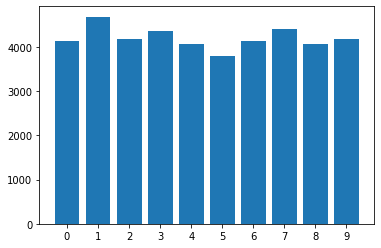

In [4]:
# view class distribution
x = [i for i in range(0,10)]
plt.bar(x, d['label'].value_counts().sort_index())
plt.xticks(x)
plt.show()

# preprocessing

In [5]:
# convert to matrix
d = d.values
print('done')

done


In [6]:
# separate features (X) from labels (y)
d_X = d[:,1:] # (42000, 784)
d_y = d[:,0]  # (42000,)
d_y = d_y[:, None]

# normalise features
print(f'range before normalisation: {[d_X.min(),d_X.max()]}')
d_X = d_X / 255
print(f'range after normalisation: {[d_X.min(),d_X.max()]}')

range before normalisation: [0, 255]
range after normalisation: [0.0, 1.0]


In [7]:
def train_val_split(X, y, val_size=0.25):
    """splits dataset into training and validation set"""
    
    d_size = X.shape[0]
    sep = int(val_size * d_size)
    inds = list(range(d_size))
    random.shuffle(inds)
    train_inds, val_inds = inds[sep:], inds[:sep]

    X_t, X_v = d_X[train_inds, :], d_X[val_inds, :]
    y_t, y_v = d_y[train_inds], d_y[val_inds]
    
    return X_t, X_v, y_t, y_v


In [8]:
# split into training and validation set
X_trn, X_val, y_trn, y_val = train_val_split(d_X, d_y)
print('done')

print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

done
(31500, 784) (10500, 784) (31500, 1) (10500, 1)


# Functions

In [82]:

def relu(x):
    return np.maximum(x, 0)

def relu_der(x):
    return (x > 0)

def softmax(x):
    exps = np.exp(x)
    exps_sums = exps.sum(axis=1)
    return exps / exps_sums[:,None]    

def softmax_stable(x):
    exps = np.exp(x - np.max(x))
    exps_sums = exps.sum(axis=1)
    return exps / exps_sums[:,None]

def J(y, yhat):
    # y -> m-dimensional vector (ground truth) ; yhat -> m x 10 matrix (predictions)
    # one-hot encode y
    targets = y.reshape(-1)
    y_onehot = np.eye(yhat.shape[1])[targets]
    
    #return -np.sum( y_onehot * np.log(yhat) ) # this is not stable
    return -np.sum( y_onehot * np.log(yhat + 1e-8))


In [ ]:
n = 784
h = 20
out = 10
m = 200
loss_hx = []
epochs = 10

# initialise parameters

w1 = np.random.normal(0, 1, (n, h))
w2 = np.random.normal(0, 1, (h, out))
b1 = np.zeros((h, 1))
b2 = np.zeros((out, 1))

for epoch in range(epochs):
    
    epoch_loss = 0

    for i in range(0, 31500, 100): 

        #X_trn.shape -> (31500, 784); y_trn.shape -> (31500, 1)

        x = X_trn[i:i+100, :] 
        y = y_trn[i:i+100,:]
        
        print(f'epoch{epoch}: w1 isnan?:{np.isnan(np.sum(w1))}')
        
        # feedforward
        z1 = np.dot(x, w1) + b1.T
        a1 = relu(z1)
        z2 = np.dot(a1,w2) + b2.T
        a2 = softmax_stable(z2)
        
        epoch_loss += J(y, a2)

        delta_a2 = a2 - y
        delta_a1 = np.dot(delta_a2, w2.T) * relu_der(z1)
        
        dJ_dw2 = np.dot(a1.T, delta_a2) / m
        
        dJ_dw1 = np.dot(x.T, delta_a1) / m
        # grad descent
        lr = 0.001
        w1 -= lr * dJ_dw1
        b1 -= lr * np.sum(delta_a1.T, axis=1, keepdims=True) / m
        w2 -= lr * dJ_dw2
        
        b2 -= lr * np.sum(delta_a2.T, axis=1, keepdims=True) / m

    loss_hx.append(epoch_loss)


In [93]:
loss_hx

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [91]:
a1

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
        # backprop

        #dJ_dz2 = a2 - y_onehot
        #dz2_dw2 = a1
        #dJ_w2 = np.dot(dz2_dw2.T, dJ_dz2)
        #dJ_b2 = dJ_dz2

        #dz2_da1 = w2
        #dJ_da1 = np.dot(dJ_dz2, dz2_da1.T)
        #da1_dz1 = relu_der(z1)
        #dz1_dw1 = x
        #dJ_w1 = np.dot(dz1_dw1.T, da1_dz1 * dJ_da1)
        #dJ_b1 = dJ_da1 * da1_dz1
        #print(dJ_da1.shape, da1_dz1.shape)
        
        #w1 -= lr * dJ_w1
        #b1 -= lr * np.sum(dJ_b1, axis=1, keepdims=True) / m

        #w2 -= lr * dJ_w2
        #b2 -= lr * np.sum(dJ_b2, axis=1, keepdims=True) / m

In [104]:
# checking softmax

huh = np.random.uniform(low=0.5, high=8, size=(10,5))

softmax_stable(huh).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])